In [1]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import tiff_file
import ddm_clean 

import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

nd2reader module not found. Reading of .nd2 files disabled.


C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


## Image autocorrelation function defined below

In [2]:
def im_corr(im, filter=False, filtersize=80, bin=True, binsize=2):
    '''
    Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
        
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation
    '''
    # Crop image
    image = im[:1440, :1440]
        
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)
        
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #radial average taken
    rav_corr = ddm_clean.newRadav(corr_im)
    
    #return corr_im, rav_corr
    return rav_corr

def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

def last_3chars(x):
    return((x.split('\\')[-1])[-7:-4])
#last_3chars(files[0])

###define function to find characteristic correlation lengths of SIA curves 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

one_over_e = 1.0/np.exp(1) #characteristic decay length 1/e = 0.36787944117144233... 
#print(one_over_e)

In [69]:
###################################################################################
# Specify where the data is and file name for image (or image sequence)           #
###################################################################################

directory = "Z"
exp = "8-15-22_s2_EA,WT,1-3WT"
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\reordered tiffs\\" #bottom_row_t01\\
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*")
#files = sorted(files, key = last_3chars)
print("found %i files" % len(files))
print(int((len(files))/3))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 27 files
9
 0 	 bottom_row_t1.tif
 1 	 bottom_row_t2.tif
 2 	 bottom_row_t3.tif
 3 	 bottom_row_t4.tif
 4 	 bottom_row_t5.tif
 5 	 bottom_row_t6.tif
 6 	 bottom_row_t7.tif
 7 	 bottom_row_t8.tif
 8 	 bottom_row_t9.tif
 9 	 middle_row_t1.tif
 10 	 middle_row_t2.tif
 11 	 middle_row_t3.tif
 12 	 middle_row_t4.tif
 13 	 middle_row_t5.tif
 14 	 middle_row_t6.tif
 15 	 middle_row_t7.tif
 16 	 middle_row_t8.tif
 17 	 middle_row_t9.tif
 18 	 top_row_t1.tif
 19 	 top_row_t2.tif
 20 	 top_row_t3.tif
 21 	 top_row_t4.tif
 22 	 top_row_t5.tif
 23 	 top_row_t6.tif
 24 	 top_row_t7.tif
 25 	 top_row_t8.tif
 26 	 top_row_t9.tif


In [4]:
###### # specify each condition (frame_names) and the time points of data collection (time_array) #
############################################################################################
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
time_array =  [0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
#[0.5, 4.5, 8, 12, 20, 24]
#[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]  
#[0.5, 3.2, 17.75, 20, 22, 24.25, 26, 41.75, 44]
#[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
fig_size = 10,10/1.618
font_size = 16
dpi_num = 800
pixel_size = 0.364 # 4*0.091 = 0.364

print((files[0]))
eg_im= tiff_file.imread(files[0])
print(eg_im.shape)
frames_per_tiff = int(eg_im.shape[0])
print(frames_per_tiff)
arr_length = int((len(files))/3)
print(arr_length)

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


Z:\Gregor L\__Kai Colloids\8-15-22_s2_EA,WT,1-3WT\all tiff files\bottom_row_t1.tif
(5, 1440, 1920)
5
9


###################################################################################################
# makes new tiff files, each new tiff has all consecutive time points for each specific condition #
###################################################################################################
arr_length = int((len(files))/3)

for j in range(frames_per_tiff-1):
    frame_num = str(j+1)

    for i in range(arr_length):    
        br_frame1_im = tiff_file.imread(files[i],key=[j])
        mr_frame1_im = tiff_file.imread(files[i+arr_length],key=[j])
        tr_frame1_im = tiff_file.imread(files[i+(arr_length*2)],key=[j])
        #print(br_frame1_im.shape[0])
        if i==0:
            br_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
            mr_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
            tr_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
        br_frame1[i] = br_frame1_im
        mr_frame1[i] = mr_frame1_im
        tr_frame1[i] = tr_frame1_im

    tiff_file.imsave(data_dir2 +'br_'+frame_names[j]+'.tif', br_frame1)
    tiff_file.imsave(data_dir2 +'mr_'+frame_names[j]+'.tif', mr_frame1)
    tiff_file.imsave(data_dir2 +'tr_'+frame_names[j]+'.tif', tr_frame1)
    print(tr_frame1.shape)

#####################################################
# **optional** preview of tiff files to be analyzed #
#####################################################
br_frame1 = tiff_file.imread(data_dir2 +'tr_'+frame_names[0]+'.tif')

plt.figure(figsize=(10,10))    
for i in range (arr_length):
    ax = plt.subplot(4,3,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("frame %i" % int(i + 1), fontsize=10)
    ax.matshow(br_frame1[i], cmap = 'bone') #fig.set_cmap('hot') 
    plt.axis('off')
    plt.tight_layout(pad=.25)

In [5]:
im_array = [0.0] * int(len(files))
br_corr_rad_array = [0.0] * int(len(files))
mr_corr_rad_array = [0.0] * int(len(files))
tr_corr_rad_array = [0.0] * int(len(files))

all_xvalues = [0.0] * int(len(files))

<IPython.core.display.Javascript object>


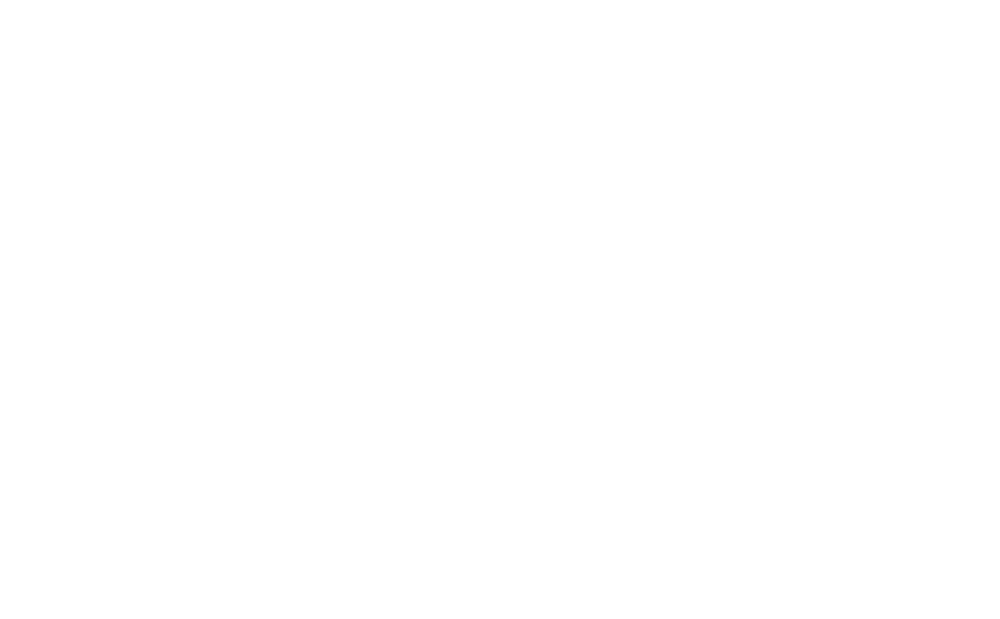

[0.08595334026467283, 0.1618480706513363, 0.16468274277211056, 0.13938660779843023, 0.11686167650747908, 0.12926331730362559, 0.16165154783330352, 0.15060447097781585, 0.12758318494885015]


<ipython-input-6-7d062f3b69d2>:56: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, '1-3 kA-WT (frame 1) filter= None')

In [6]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 0
cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)
    ax.set_xscale("log")
print(mean_plat_vals_array)    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [7]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [8]:
print(all_xvalues[-1])

130.676


<IPython.core.display.Javascript object>


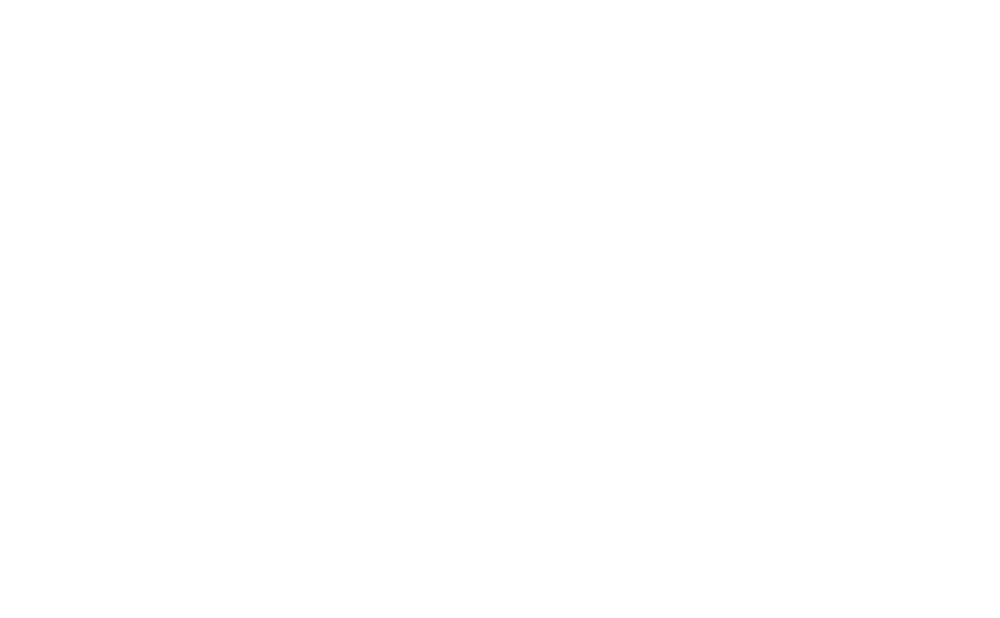

Text(0.5, 1.0, '1-3 kA-WT (frame 1) filter= None')

In [9]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [10]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


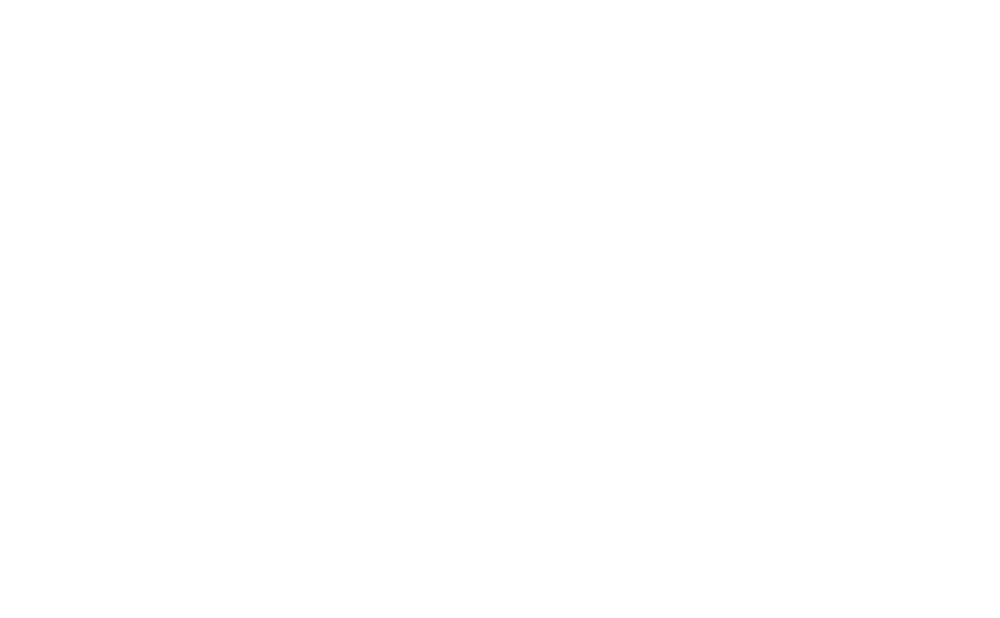

<ipython-input-11-759324e6c1c7>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, '1-3 kA-WT (frame 1) filter= None')

In [11]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [12]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


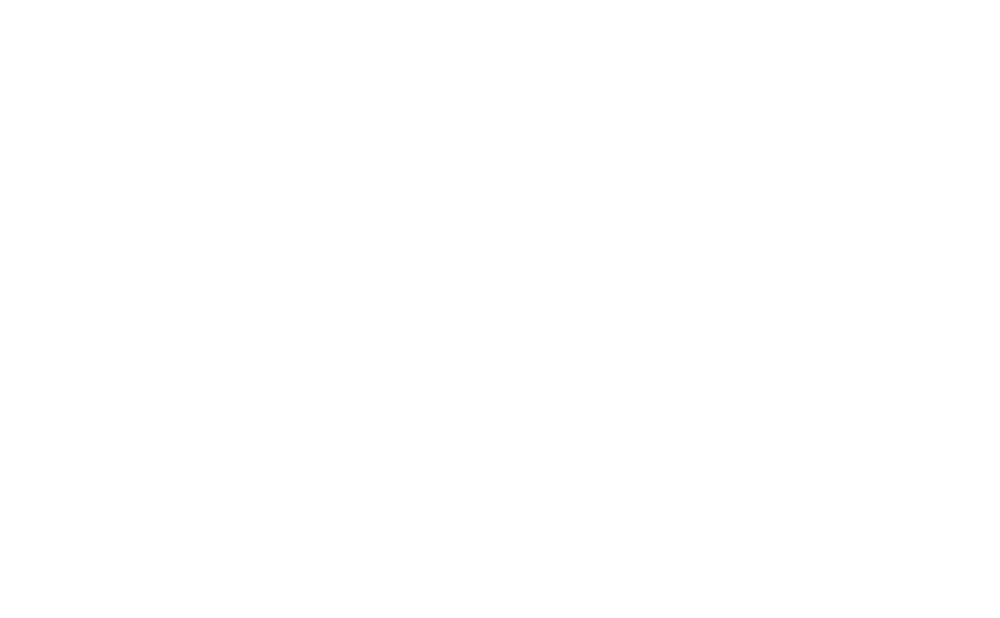

[5.325565565565566, 6.871221221221222, 6.472342342342343, 4.9765465465465475, 5.624724724724725, 5.076266266266267, 5.6745845845845855, 6.970940940940942, 7.020800800800802]


<ipython-input-13-f6ad9893fc04>:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [13]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame1_results_dict = {}
frame1_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 50, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame1_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame1_results_dict[time]["x vals"] = all_xvalues
    frame1_results_dict[time]["br y vals"] = br_y_array
    frame1_results_dict[time]["mr y vals"] = mr_y_array
    frame1_results_dict[time]["tr y vals"] = tr_y_array
    
    frame1_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame1_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame1_results_dict[time]["x fit vals"] = x_fit_values
    frame1_results_dict[time]["br fit vals"] = br_fit_values
    frame1_results_dict[time]["mr fit vals"] = mr_fit_values
    frame1_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame1_results_dict[time]["br corr length"] = br_corr_length
    frame1_results_dict[time]["mr corr length"] = mr_corr_length
    frame1_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
#plt.axvline(x=131, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [14]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


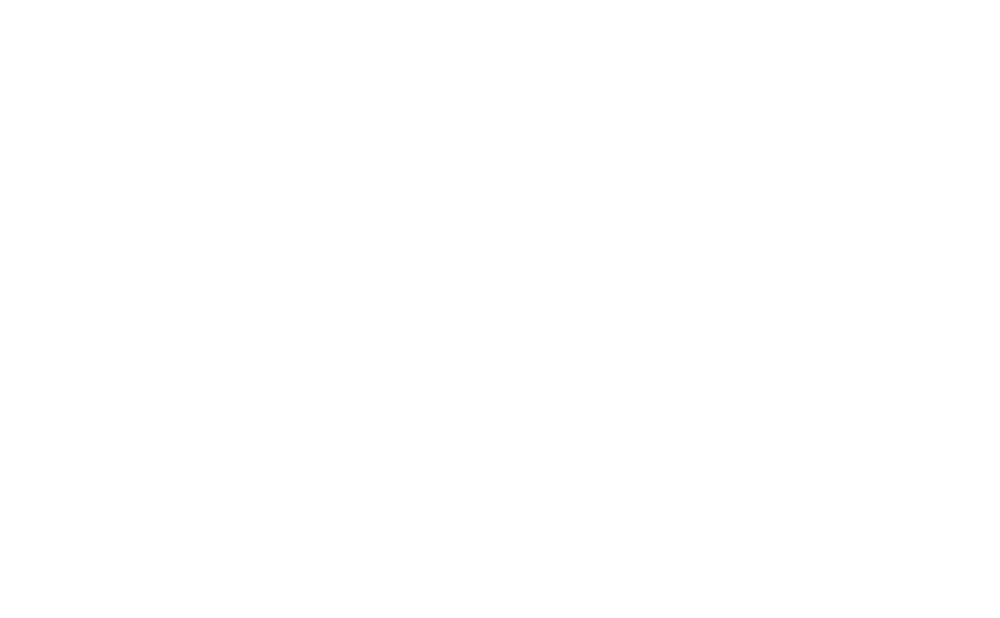

[6.15656323 8.35039706 7.7686987  7.38643977 5.35880547 7.30334001
 7.41967968 7.50277945 7.61911912]


Text(0.5, 1.0, '1-3 kA-WT (frame 1) filter= None')

In [15]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Reds')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)
print(mean_corr_length_array)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,14)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

In [16]:
###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


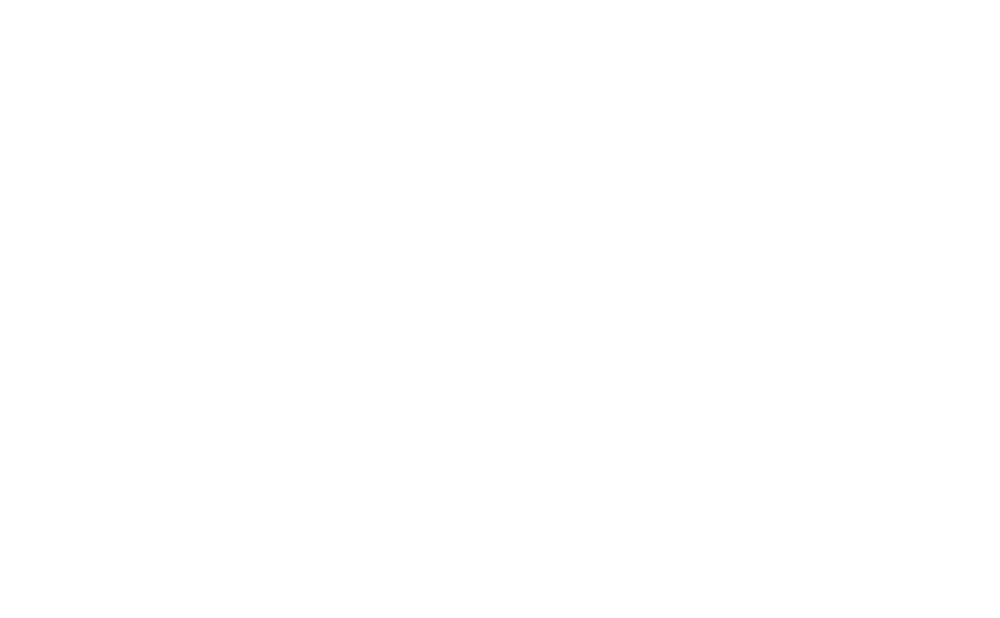

In [17]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [18]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame1_results_dict[time]['x vals'])):
            writer.writerow([frame1_results_dict[time]['x vals'][i], frame1_results_dict[time]['br y vals'][i],
                            frame1_results_dict[time]['mr y vals'][i], frame1_results_dict[time]['tr y vals'][i],
                            frame1_results_dict[time]['avg y vals'][i], frame1_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame1_results_dict[time]['x fit vals'])):
            writer.writerow([frame1_results_dict[time]['x fit vals'][i], frame1_results_dict[time]['br fit vals'][i],
                            frame1_results_dict[time]['mr fit vals'][i], frame1_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [19]:
#print(results_dict)

<IPython.core.display.Javascript object>


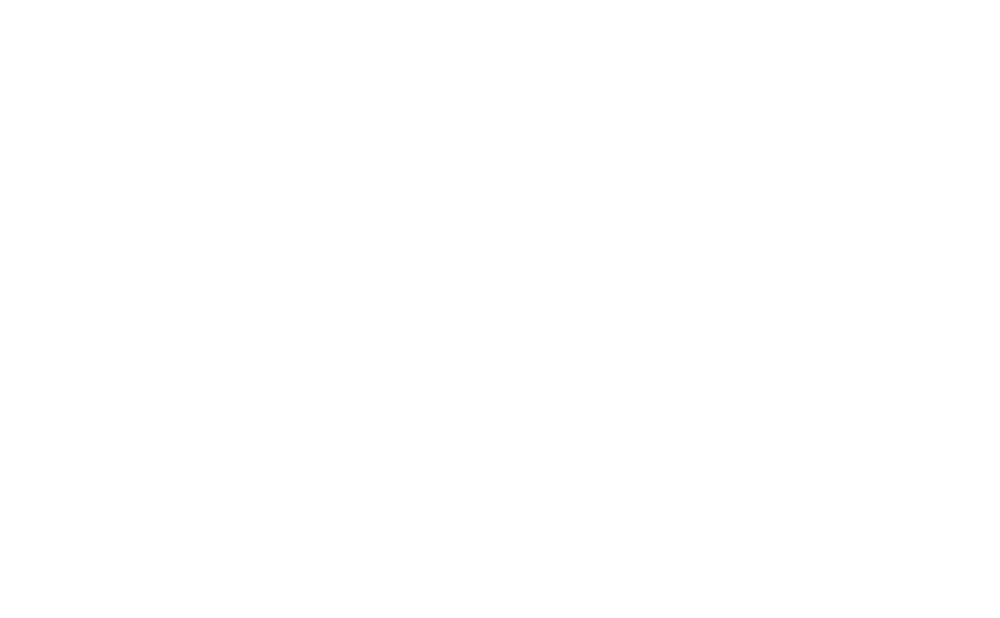

<ipython-input-20-a58ca328c664>:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'WT (no kA) (frame 2) filter= None')

In [20]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 1
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [21]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


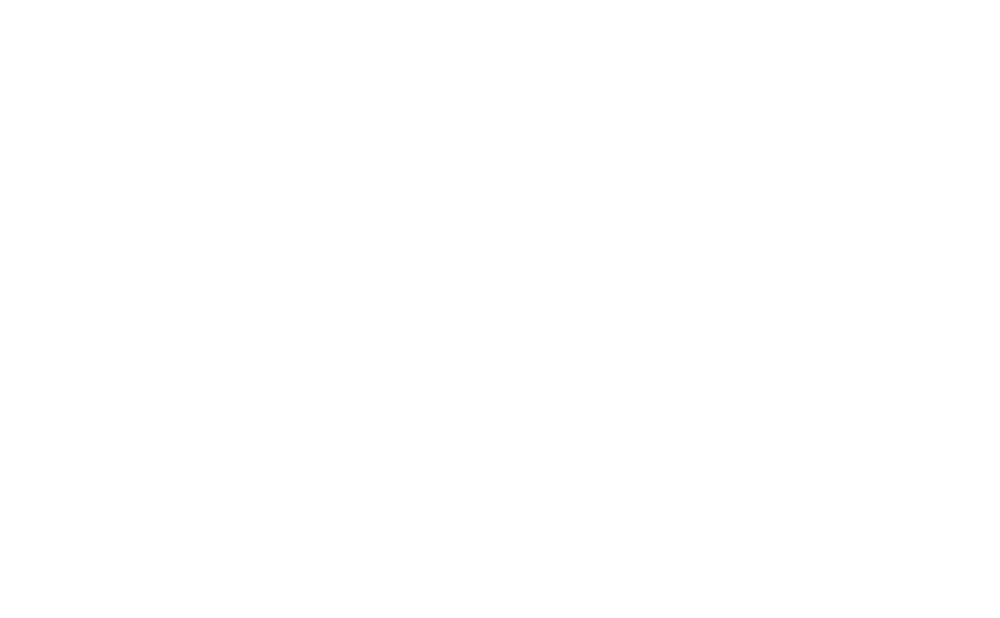

Text(0.5, 1.0, 'WT (no kA) (frame 2) filter= None')

In [22]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=(font_size-6))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [23]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


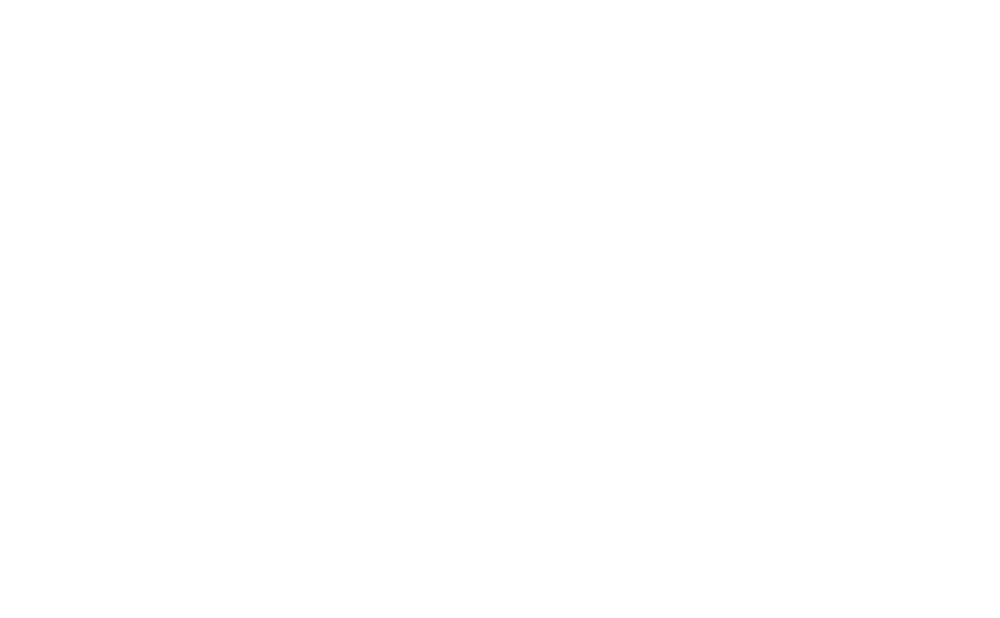

<ipython-input-24-a1cfbb5c83b9>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'WT (no kA) (frame 2) filter= None')

In [24]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [25]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


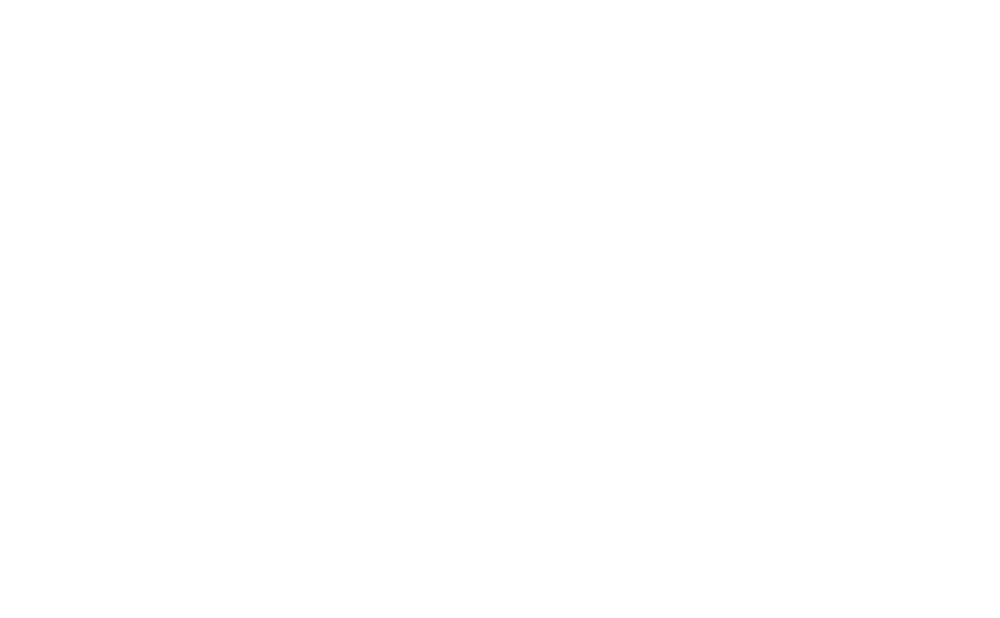

[7.0706606606606615, 5.774304304304305, 7.020800800800802, 6.422482482482483, 4.777107107107108, 5.774304304304305, 5.375425425425426, 6.173183183183184, 6.472342342342343]


<ipython-input-26-9dfa368f08d7>:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [26]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame2_results_dict = {}
frame2_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 50, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame2_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame2_results_dict[time]["x vals"] = all_xvalues
    frame2_results_dict[time]["br y vals"] = br_y_array
    frame2_results_dict[time]["mr y vals"] = mr_y_array
    frame2_results_dict[time]["tr y vals"] = tr_y_array
    
    frame2_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame2_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame2_results_dict[time]["x fit vals"] = x_fit_values
    frame2_results_dict[time]["br fit vals"] = br_fit_values
    frame2_results_dict[time]["mr fit vals"] = mr_fit_values
    frame2_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame2_results_dict[time]["br corr length"] = br_corr_length
    frame2_results_dict[time]["mr corr length"] = mr_corr_length
    frame2_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [27]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


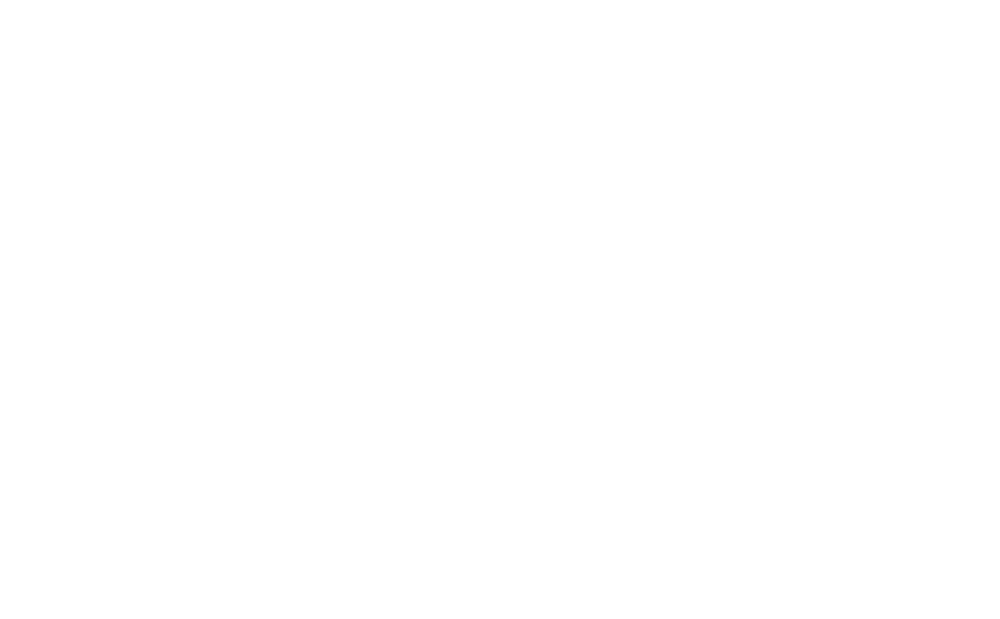

In [28]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Blues')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,14)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


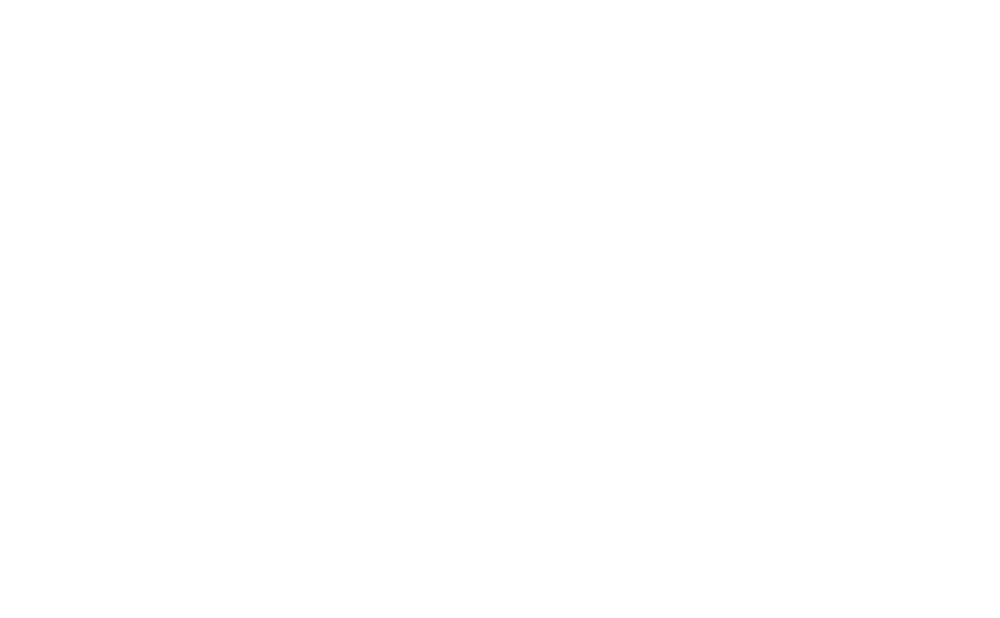

In [29]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [30]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame2_results_dict[time]['x vals'])):
            writer.writerow([frame2_results_dict[time]['x vals'][i], frame2_results_dict[time]['br y vals'][i],
                            frame2_results_dict[time]['mr y vals'][i], frame2_results_dict[time]['tr y vals'][i],
                            frame2_results_dict[time]['avg y vals'][i], frame2_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame2_results_dict[time]['x fit vals'])):
            writer.writerow([frame2_results_dict[time]['x fit vals'][i], frame2_results_dict[time]['br fit vals'][i],
                            frame2_results_dict[time]['mr fit vals'][i], frame2_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

<IPython.core.display.Javascript object>


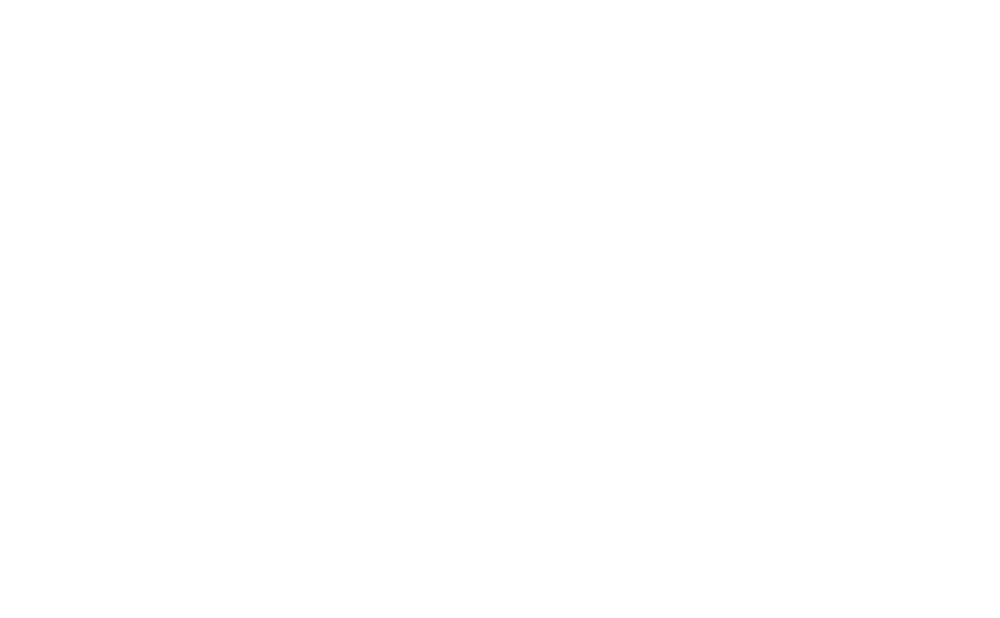

<ipython-input-31-08a4b09dab10>:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'EA KaiC (frame 3) filter= None')

In [31]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [32]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


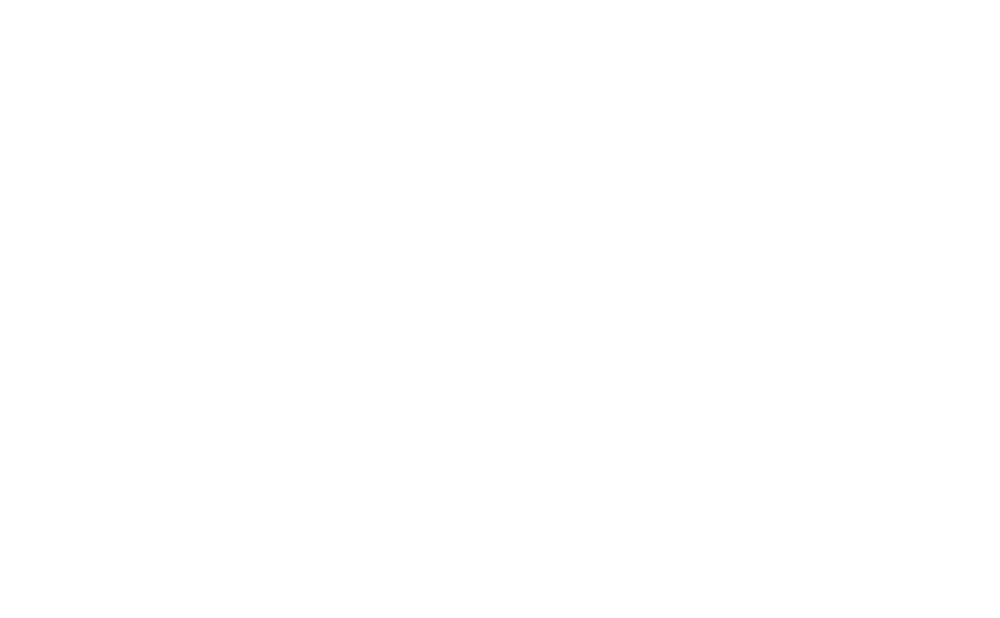

Text(0.5, 1.0, 'EA KaiC (frame 3) filter= None')

In [33]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=(font_size-6))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [34]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


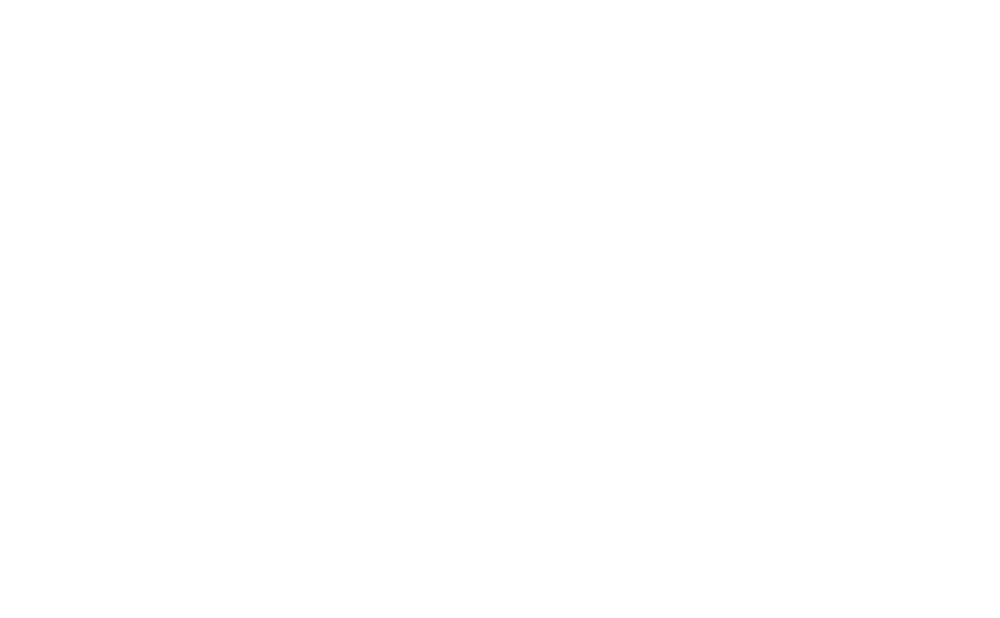

<ipython-input-35-c2d7b616774b>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'EA KaiC (frame 3) filter= None')

In [35]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [36]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


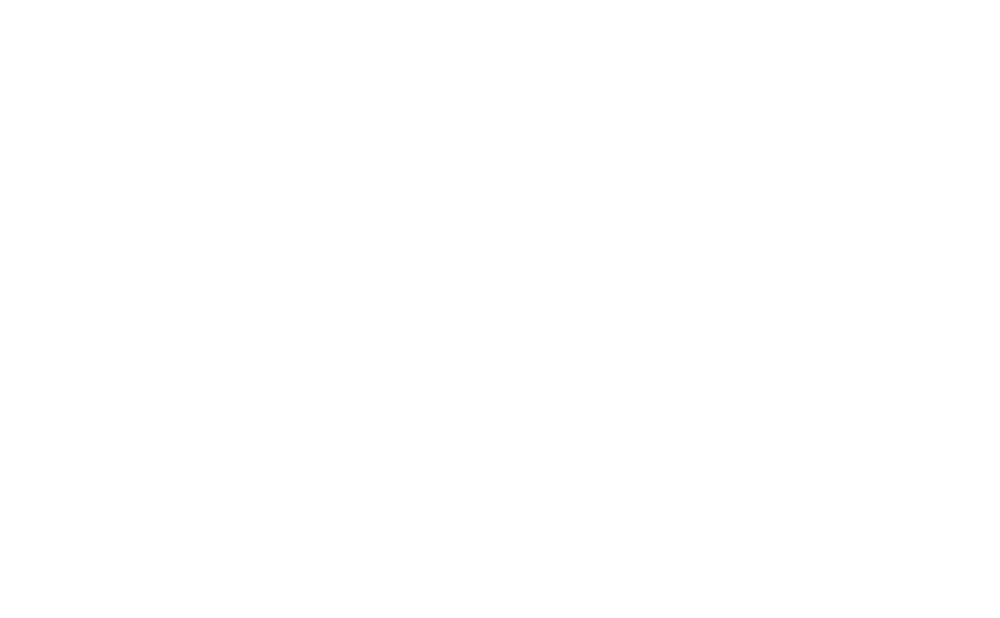

[6.3726226226226235, 5.574864864864866, 5.724444444444445, 7.71883883883884, 6.970940940940942, 8.616316316316317, 6.422482482482483, 12.156366366366367, 8.566456456456457]


<ipython-input-37-5291cd03cace>:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [37]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame3_results_dict = {}
frame3_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -1 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 50, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame3_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame3_results_dict[time]["x vals"] = all_xvalues
    frame3_results_dict[time]["br y vals"] = br_y_array
    frame3_results_dict[time]["mr y vals"] = mr_y_array
    frame3_results_dict[time]["tr y vals"] = tr_y_array
    
    frame3_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame3_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame3_results_dict[time]["x fit vals"] = x_fit_values
    frame3_results_dict[time]["br fit vals"] = br_fit_values
    frame3_results_dict[time]["mr fit vals"] = mr_fit_values
    frame3_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame3_results_dict[time]["br corr length"] = br_corr_length
    frame3_results_dict[time]["mr corr length"] = mr_corr_length
    frame3_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [38]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


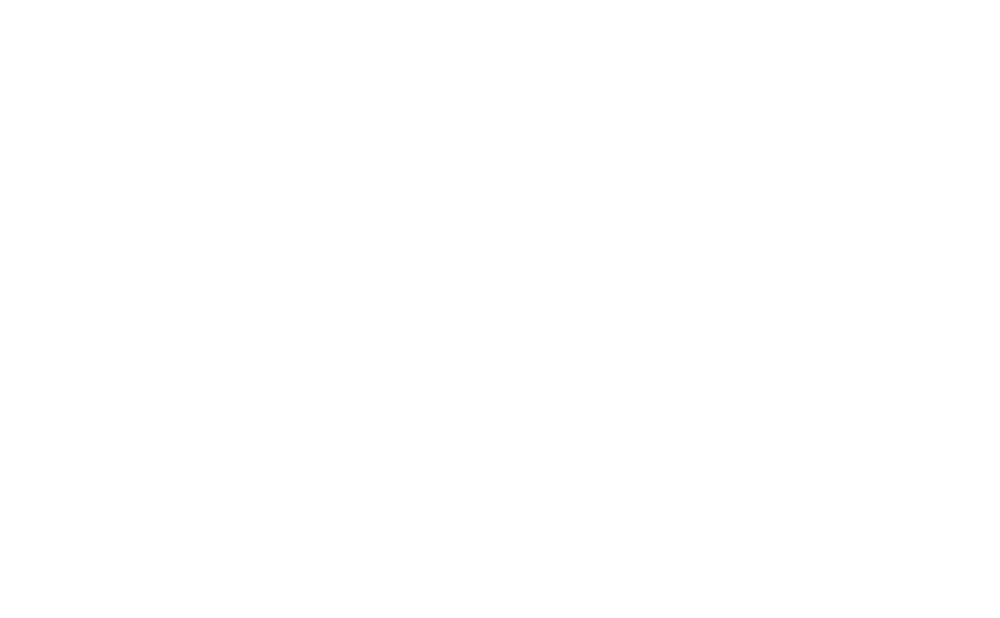

Text(0.5, 1.0, 'EA KaiC (frame 3) filter= None')

In [39]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Greens')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,16)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

In [40]:
###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


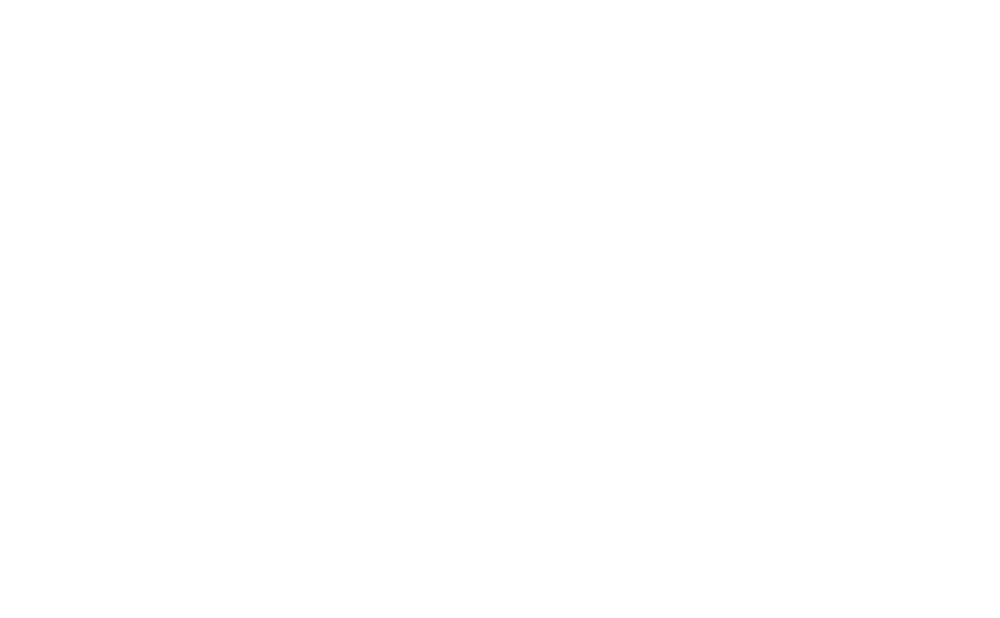

In [41]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [42]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame3_results_dict[time]['x vals'])):
            writer.writerow([frame3_results_dict[time]['x vals'][i], frame3_results_dict[time]['br y vals'][i],
                            frame3_results_dict[time]['mr y vals'][i], frame3_results_dict[time]['tr y vals'][i],
                            frame3_results_dict[time]['avg y vals'][i], frame3_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame3_results_dict[time]['x fit vals'])):
            writer.writerow([frame3_results_dict[time]['x fit vals'][i], frame3_results_dict[time]['br fit vals'][i],
                            frame3_results_dict[time]['mr fit vals'][i], frame3_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

<IPython.core.display.Javascript object>


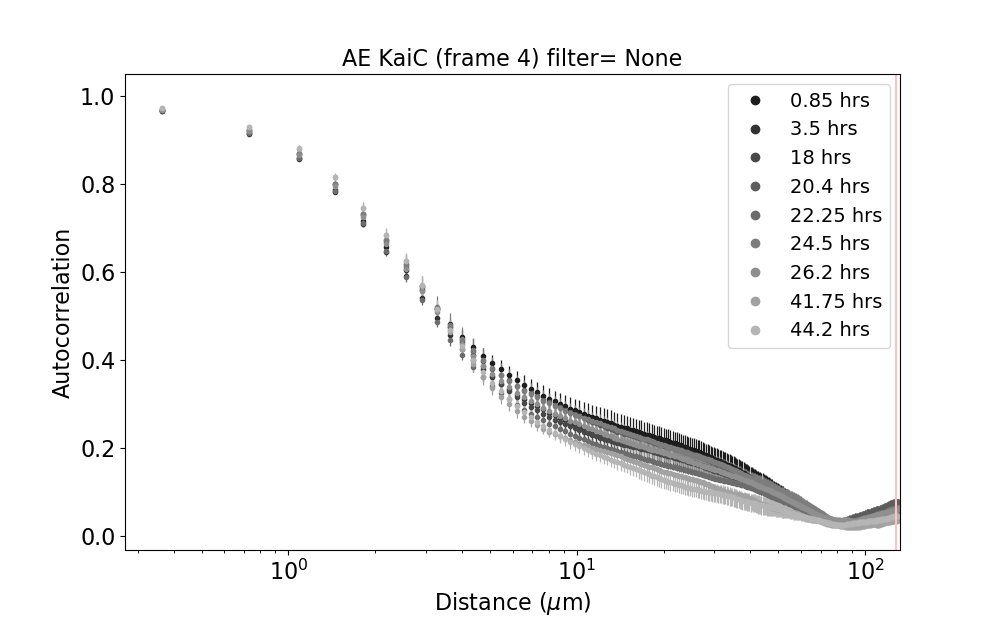

<ipython-input-55-b7e1a795e9bf>:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'AE KaiC (frame 4) filter= None')

In [55]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False #True #False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 3
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [56]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


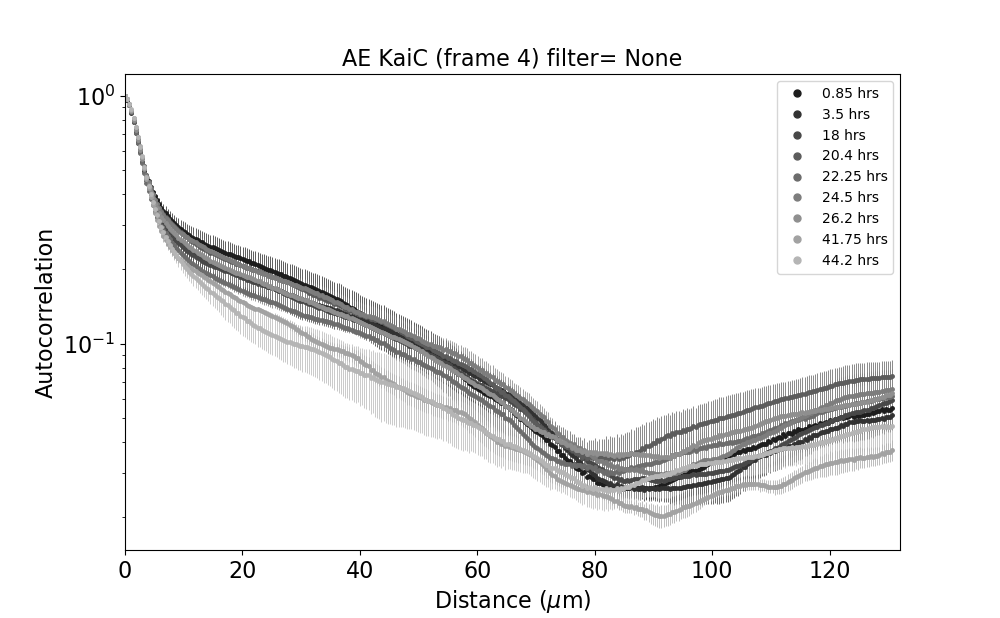

Text(0.5, 1.0, 'AE KaiC (frame 4) filter= None')

In [58]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=(font_size-6))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [59]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


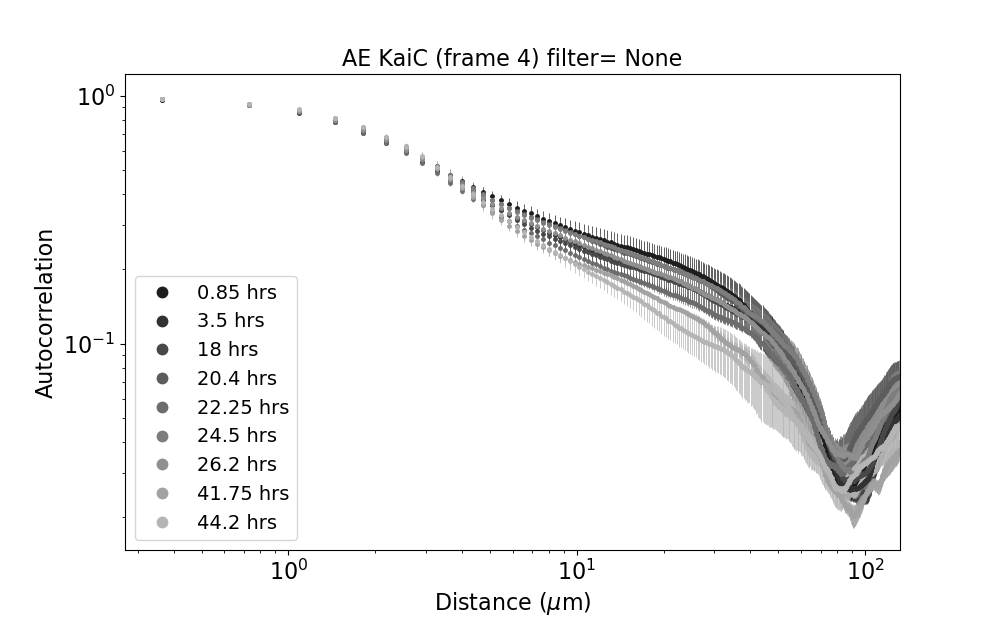

<ipython-input-61-92ca832097ae>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'AE KaiC (frame 4) filter= None')

In [61]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [62]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


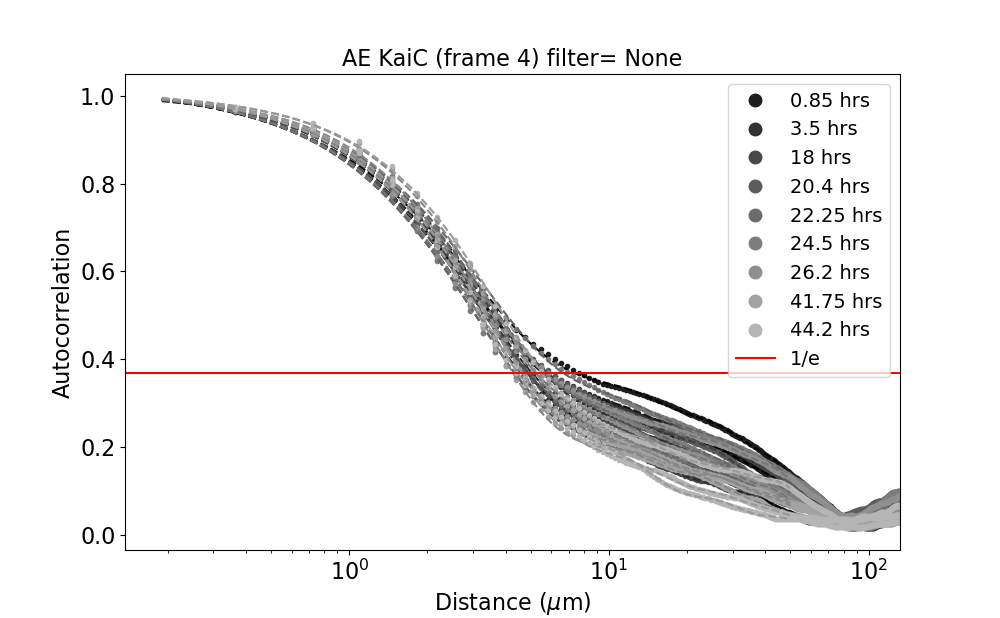

[4.876826826826828, 4.8269669669669675, 5.624724724724725, 5.824164164164165, 4.876826826826828, 4.328368368368369, 5.6745845845845855, 4.677387387387388, 4.428088088088089]


<ipython-input-63-cf632bcd7acb>:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [63]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame4_results_dict = {}
frame4_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 50, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame4_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame4_results_dict[time]["x vals"] = all_xvalues
    frame4_results_dict[time]["br y vals"] = br_y_array
    frame4_results_dict[time]["mr y vals"] = mr_y_array
    frame4_results_dict[time]["tr y vals"] = tr_y_array
    
    frame4_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame4_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame4_results_dict[time]["x fit vals"] = x_fit_values
    frame4_results_dict[time]["br fit vals"] = br_fit_values
    frame4_results_dict[time]["mr fit vals"] = mr_fit_values
    frame4_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame4_results_dict[time]["br corr length"] = br_corr_length
    frame4_results_dict[time]["mr corr length"] = mr_corr_length
    frame4_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 132) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [64]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


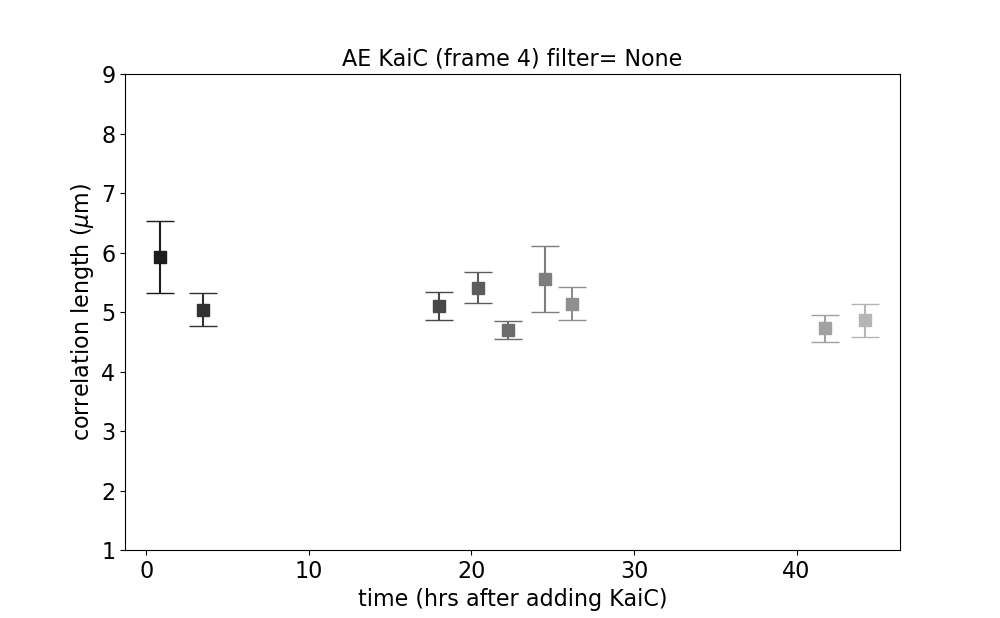

Text(0.5, 1.0, 'AE KaiC (frame 4) filter= None')

In [65]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Greys')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,9)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

In [66]:
###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


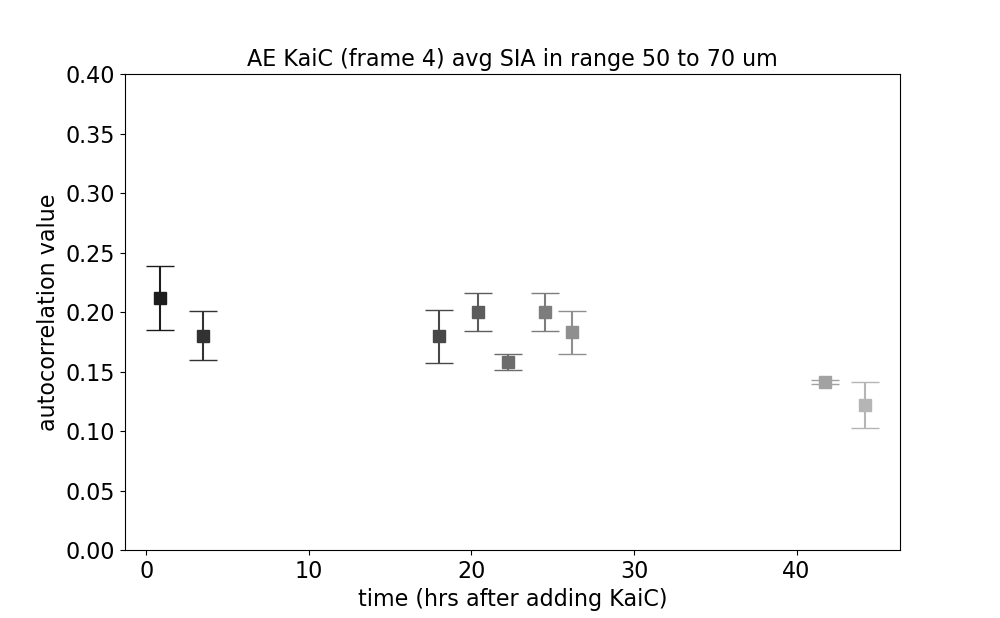

In [67]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [54]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame4_results_dict[time]['x vals'])):
            writer.writerow([frame4_results_dict[time]['x vals'][i], frame4_results_dict[time]['br y vals'][i],
                            frame4_results_dict[time]['mr y vals'][i], frame4_results_dict[time]['tr y vals'][i],
                            frame4_results_dict[time]['avg y vals'][i], frame4_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame4_results_dict[time]['x fit vals'])):
            writer.writerow([frame4_results_dict[time]['x fit vals'][i], frame4_results_dict[time]['br fit vals'][i],
                            frame4_results_dict[time]['mr fit vals'][i], frame4_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()